# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p, g
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_lambda_2_theory
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
import uncertainties
import matplotlib.transforms as mtransforms
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-15 13:40:28,139 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [17]:
# Load dataset
var_keep = ['temp', 'sphum', 'height']
# exp_dir = 'tau_sweep/aquaplanet/'
exp_dir = ['tau_sweep/aquaplanet/', 'aquaplanet/vary_depth/depth=1/']
exp_names = ['k=1_5', 'k=2', 'k=3_5']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_dir)
n_kappa = len(exp_names)
ds = [[], []]
albedo = [[], []]
tau_sw = [[], []]
tau_lw = [[], []]
depth = []
with tqdm(total=n_exp*n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[i] + exp_names[j])
            ds[i] += [ds_use]
            namelist = isca_tools.load_namelist(exp_dir[i] + exp_names[j])  # Need this for albedo_value
            albedo[i] += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw[i] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw[i] += [namelist['two_stream_gray_rad_nml']['odp']]
            if j==0:
                depth += [namelist['mixed_layer_nml']['depth']]
            pbar.update(1)
tau_lw = np.asarray(tau_lw)

100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [19]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [21]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = [[], []]
with tqdm(total=n_exp*n_kappa, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds[i][j].sel(time=slice(use_time_start, np.inf))[var_keep]
            ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
            ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
    
            if season == 'summer' or season == 'winter':
                # Only consider summer as has expected circulation
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
                # Combine hemispheres and average over longitude, time and latitude.
                # Note that April, May, June, October, November and December will not be included in this dataset
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all[i] += [ds_use.load()]
            pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0][0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0][0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [22]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0][0].lat)
n_pressure = ds_all[0][0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0][0].lat))     # latitude area weighting is just the cosine

temp_mean = np.zeros((n_exp, n_kappa, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mean = np.zeros((n_exp, n_kappa, n_pressure, n_lat))
sphum_mean = np.zeros((n_exp, n_kappa, n_lat))
z_mean = np.zeros((n_exp, n_kappa, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_kappa, n_pressure, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_kappa, n_lat, n_quant_all))
with tqdm(total=n_exp*n_kappa*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_kappa):
            ds_use = ds_all[i][j]
            temp_mean[i, j] = ds_use.temp.mean(dim='lon_time')
            sphum_mean[i, j] = ds_use.sphum.isel(pfull=ind_surf).mean(dim='lon_time')
            z_mean[i, j] = ds_use.height.isel(pfull=ind_ft).mean(dim='lon_time')
            mse = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)
            mse_mean[i, j] = mse.mean(dim='lon_time')
            for k in range(n_lat):
                for q, quant in enumerate(quantiles_all):
                    use_ind = get_quant_ind(ds_use.temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                    sphum_quant3[i, j, k, q] = ds_use.sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                    z_quant3[i, j, k, q] = ds_use.height.isel(pfull=ind_ft)[k, use_ind].mean()
                    mse_quant3[i, j, :, k, q] = mse[:, k, use_ind].mean(dim='lon_time')
                    temp_quant3[i, j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                    pbar.update(1)

100%|██████████| 10692/10692 [00:43<00:00, 245.11it/s]


### CAPE and $\epsilon=h(x)-h^*_{FT}(x)$
From above, we see that $\lambda_1 \neq 1$ implying that CAPE changes with warming. Below, I show that the CAPE has an almost 1:1 relationship with near-surface temperature. 
This increase in CAPE is not consistent with the assumption of CQE.

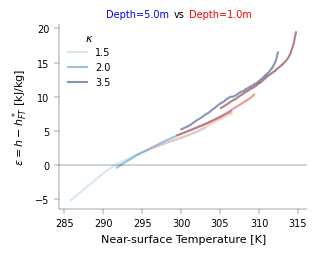

In [60]:
epsilon_quant3 = mse_quant3[:, :, 0] - mse_quant3[:, :, 1]

save_epsilon_fig = False
# colors_exp = plt.cm.jet(np.linspace(0, 1, n_kappa))
colors_exp = [plt.cm.Blues(np.linspace(0, 1, n_kappa+1))[1:], plt.cm.Reds(np.linspace(0, 1, n_kappa+1))[1:]]
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    for j in range(n_kappa):
        ax.plot(np.average(temp_quant3[i, j, ind_surf], axis=0, weights=lat_weights), 
                np.average(epsilon_quant3[i, j], axis=0, weights=lat_weights), color=colors_exp[i][j], label=f'{tau_lw[i][j]}' if i==0 else None, 
        alpha=0.5, lw=1.5)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(title='$\kappa$')
ax.set_ylabel('$\epsilon=h-h^*_{FT}$ [kJ/kg]')
ax.set_xlabel('Near-surface Temperature [K]')
fig.text(0.37, 0.9, f"Depth={depth[0]}m", ha="center", va="bottom", size=7,color="blue")
fig.text(0.5, 0.9, "vs", ha="center", va="bottom", size=7)
fig.text(0.63,0.9,f"Depth={depth[1]}m", ha="center", va="bottom", size=7,color="red")
if save_epsilon_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### MSE as function of temperature
To delve more into the CAPE trend above, below I plot $h(x)$ (solid) and $h^*_{FT}(x)$ as a function of near-surface temperature. Both appear to show a 1:1 relationship and there doesn't seem to be anything stopping $h$ exceeding $h^*_{FT}$ as we may expect if convection was happening.

For each simulation, the line joins up all moist static energies evaluated at all 99 quantiles of near-surface temperature.

The black solid line on the left figure is $h$ with relative humidity of 0.7.

The black dotted line on the left figure is $h^*_{FT}$ evaluated at $T-30$ with $z_{500}=5500m$ i.e. with a constant lapse rate.

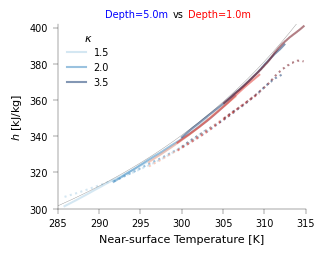

In [59]:
save_h_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    for j in range(n_kappa):
        ax.plot(np.average(temp_quant3[i, j, ind_surf], axis=0, weights=lat_weights), 
                 np.average(mse_quant3[i, j, ind_surf], axis=0, weights=lat_weights), color=colors_exp[i][j], 
                   label=f'{tau_lw[i, j]}' if i==0 else None, alpha=0.5, lw=1.5)
        ax.plot(np.average(temp_quant3[i, j, ind_surf], axis=0, weights=lat_weights), 
                 np.average(mse_quant3[i, j, ind_ft], axis=0, weights=lat_weights), color=colors_exp[i][j], 
                   linestyle=':', alpha=0.5, lw=1.5)
temp_manual_plot = np.arange(250, 320)
ax.plot(temp_manual_plot, (c_p * temp_manual_plot + L_v * 0.7*sphum_sat(temp_manual_plot, p_surface))/1000, color='k', 
        lw=ax_linewidth, alpha=0.5)
ax.legend(title='$\kappa$')
ax.set_ylabel('$h$ [kJ/kg]')
ax.set_xlabel('Near-surface Temperature [K]')
ax.set_xlim(285, 315)
ax.set_ylim(300, 402)
fig.text(0.37, 0.9, f"Depth={depth[0]}m", ha="center", va="bottom", size=7,color="blue")
fig.text(0.5, 0.9, "vs", ha="center", va="bottom", size=7)
fig.text(0.63,0.9,f"Depth={depth[1]}m", ha="center", va="bottom", size=7,color="red")
if save_h_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/h_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)